In [159]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image

In [160]:
def compare_images(images, titles=["Before", "After"]):
    plt.figure(figsize=(25,15))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [161]:
def display_image(image):
    display(Image.fromarray(image))

In [162]:
img = cv.imread("data/15/5080.jpeg")

In [163]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.blur(img,(3,3))
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
_, threshold = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# display(Image.fromarray(threshold))

In [164]:
contours, hierarchy = cv.findContours(threshold, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
convexed_contours = [cv.convexHull(c) for c in contours]

filtered_contours = []
for contour in convexed_contours:
    area = cv.contourArea(contour)
    arc = cv.arcLength(contour, True)

    if area > 1200 and area < 2000 and arc > 100 and arc < 200:
        filtered_contours.append(contour)
assert len(filtered_contours) == 3

print(len(filtered_contours))
print([(cv.contourArea(c), cv.arcLength(c, True)) for c in convexed_contours if cv.contourArea(c) > 100 and cv.arcLength(c, True) > 100 ])

# Булангийн гурван дөрвөлжин тэмдэгнүүд
# contoured = cv.drawContours(img, filtered_contours, -1, (0,255,0), 1)
# display_image(contoured)

3
[(1081.5, 954.0055389404297), (1759.0, 172.82842707633972), (3068.0, 357.1062535047531), (2235.5, 263.44017016887665), (481.0, 126.44609379768372), (486.0, 130.14485812187195), (483.0, 117.66904640197754), (400.5, 102.02865982055664), (564.5, 133.2681987285614), (4414.0, 318.5324293375015), (644.0, 157.46213793754578), (685.5, 118.66518175601959), (458.5, 107.50284254550934), (4302.0, 1446.0), (602.0, 114.0), (1344.0, 148.0), (1813.0, 173.65685415267944)]


In [165]:
contours = filtered_contours
points = []
for contour in contours:
    epsilon = 0.1 * cv.arcLength(contour, True)
    approximated_contour = cv.approxPolyDP(contour, epsilon, True)
    for point in approximated_contour.tolist():
        points.append(point[0])

points_ndarray = np.array(points)
hull = cv.convexHull(points_ndarray)
approximated_hull = cv.approxPolyDP(hull, 0.1 * cv.arcLength(hull, True), True)

top_left, top_right, bottom_left = sorted([(point[0][0], point[0][1]) for point in approximated_hull.tolist()], key=lambda p: sum(p))
bottom_right = (top_right[0], bottom_left[1])
width = max(top_right[0] - top_left[0], bottom_right[0] - bottom_left[0])
height = max(bottom_left[1] - top_left[1], bottom_right[1] - top_right[1])

print("Coordinates: ", top_left, top_right, bottom_left, bottom_right)

Coordinates:  (26, 57) (835, 57) (24, 1034) (835, 1034)


In [166]:
# Хамгийн захын цэгүүд
# for origin in top_left, top_right, bottom_left, bottom_right:
#     cv.circle(img, origin, 3, (255,0,0), 5)

# display_image(img)

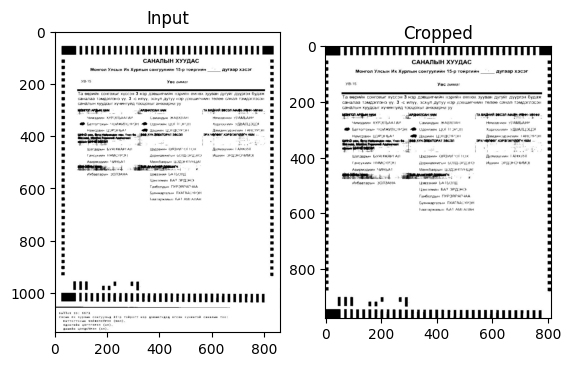

In [167]:
rows, cols, ch = img.shape
pts1 = np.float32([top_left, top_right, bottom_left, bottom_right])
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

matrix = cv.getPerspectiveTransform(pts1, pts2)
cropped = cv.warpPerspective(img, matrix, (width, height))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(cropped),plt.title('Cropped')
plt.show()

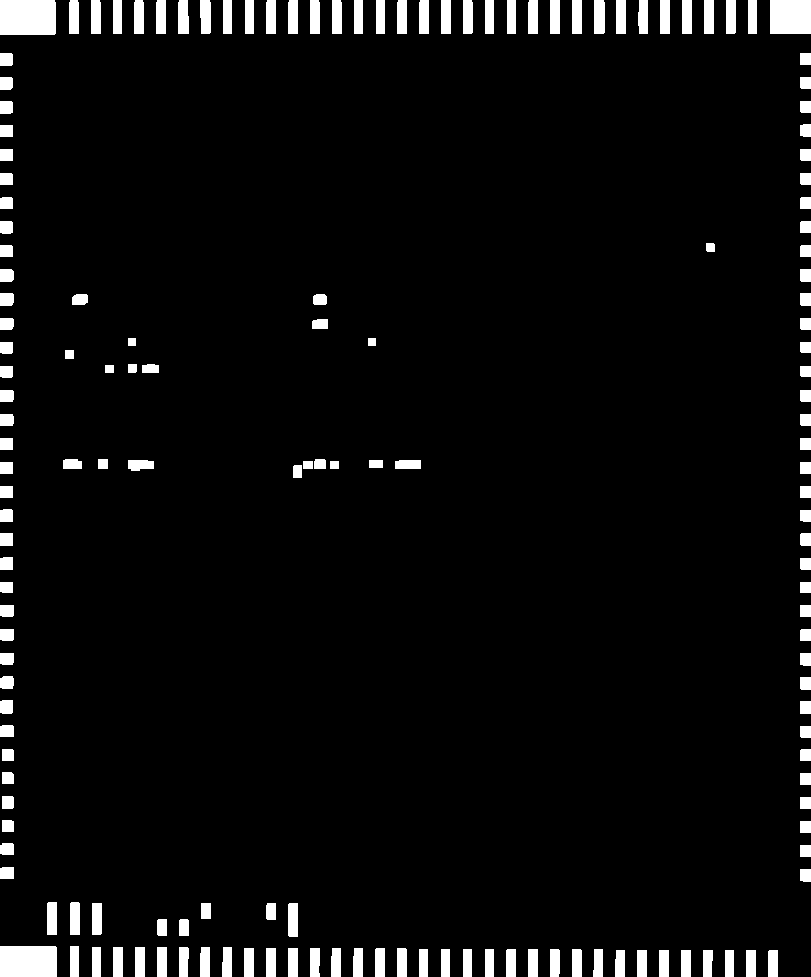

In [187]:
original = cropped
img = cv.cvtColor(original, cv.COLOR_BGR2GRAY)

kernel = np.ones((8, 8), np.uint8)
erosion = cv.dilate(img, kernel, iterations = 1)
opening = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
_, threshold = cv.threshold(opening, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


display_image(threshold)


